<a href="https://www.kaggle.com/code/chiaenchen/gan-quickdraw-dataset?scriptVersionId=172854894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import json
import numpy as np  # For numerical computing with arrays
import pandas as pd  # For data manipulation and analysis
import tensorflow as tf  # For creating and training deep learning models
import keras  # A high-level API for building deep learning models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop, Adam  # For configuring model optimization
from tensorflow.keras.models import Model  # For building a sequential model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation, Flatten, Dropout,UpSampling2D  # For building neural network layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose  # For building convolutional layers
from tensorflow.keras.layers import BatchNormalization  # For building normalization and activation layers


# QuickDraw DataSet
[https://github.com/googlecreativelab/quickdraw-dataset](http://)

In [2]:
# .npy numpy 格式
data = np.load("/kaggle/input/google-draw/full_numpy_bitmap_apple.npy")
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [3]:
#有144722 張apple 的塗鴉；28*28*1 = 784 灰階0~255
data.shape

(144722, 784)

In [4]:
#正規化
data = data/255

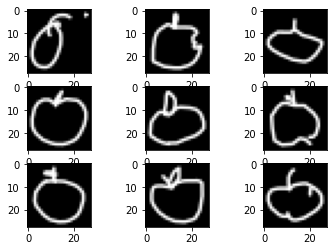

In [5]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data[i].reshape(28,28,1),cmap = "gray")

# Discriminator: CNN分類模型

In [6]:
def build_discriminator(nerul = 64, dropout = 0.2):
    img = Input(shape =(28,28,1))
    
    conv1 = Conv2D(nerul*1, kernel_size = 5, padding = "same", activation = "relu", strides=2)(img) #, strides=2
    dropout1 = Dropout(dropout)(conv1)
    conv2 = Conv2D(nerul*2, kernel_size = 5,padding = "same", activation = "relu", strides=2)(dropout1)
    dropout2 = Dropout(dropout)(conv2)
    conv3 = Conv2D(nerul*4, kernel_size = 5,padding = "same", activation = "relu", strides=2)(dropout2)
    dropout3 = Dropout(dropout)(conv3)
    conv4 = Conv2D(nerul*8,kernel_size = 5,padding = "same", activation = "relu", strides=1)(dropout3)
    flatten = Flatten()(conv4)
    
    dense = Dense(1, activation = "sigmoid")(flatten)
    
    model = Model(img, dense)
    return model

In [7]:
discriminator=build_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

In [8]:
#discriminator建立後 需要compile
discriminator.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics =["accuracy"])

# Generator: 反卷積層
輸入一維隨機雜訊(從潛在空間latent space 取樣出來的雜訊，又就是由真圖濃縮過後的特徵) => 送進密集層 => 反卷積層(上升取樣，將小圖還原成大圖): 就可將雜訊化為影像

In [9]:
latent_dim = 32
def build_generator(latent_dim = latent_dim, nerul = 64):
    #輸入雜訊
    noise = Input(shape =(latent_dim,)) # latent_dim 的值越大，代表能夠儲存的資訊越多，生成假影像的效果更好，但會增加計算量
    
    #密集層
    dense = Dense(7*7*nerul)(noise) 
    batch = BatchNormalization()(dense)
    activation = Activation(activation = "relu")(batch)
    reshape = Reshape((7,7,nerul))(activation) #被重塑 之所以為7，是因為經過兩次UpSampling2D，則會7*2*2 = 28 還原成原來圖像的維度
    dropout = Dropout(0.3)(reshape)
    
    #反卷積: UpSampling2D 和 Conv2DTranspose 在不使用 padding = "same"時，皆是把圖像放大兩倍， UpSampling2D是平均池化的逆操作，沒有新增額外參數；  Conv2DTranspose是反卷積，有額外參數
    upsample1 = UpSampling2D()(dropout) #放大圖像*2
    transpose1 = Conv2DTranspose(int(nerul/2), kernel_size = 5, padding = "same")(upsample1) #轉置
    batch = BatchNormalization()(transpose1)
    activation = Activation(activation = "relu")(batch)
    
    upsample2 = UpSampling2D()(activation) #放大圖像*2
    transpose2 = Conv2DTranspose(int(nerul/4), kernel_size = 5, padding = "same")(upsample2)
    batch = BatchNormalization()(transpose2)
    activation = Activation(activation = "relu")(batch)

    transpose3 = Conv2DTranspose(int(nerul/8), kernel_size = 5, padding = "same")(activation)
    batch = BatchNormalization()(transpose3)
    activation = Activation(activation = "relu")(batch)
    
    #輸出層: 28*28*1的影像
    image = Conv2D(1,kernel_size = 5, activation="sigmoid", padding = "same")(activation)
    
    #model
    model = Model(noise, image)
    
    return model

In [10]:
generator=build_generator()
generator.summary()
#生成器 建立後先不compile

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

# 建立 對抗式GAN
訓練Generator時，Discriminator必須參與其中，**鑑別器只是停止訓練**，但鑑別工作持續進行。**對抗式GAN會將鑑別器包起來一起編譯**，這樣就可以進行"生成器訓練"

In [11]:
# latent_dim = 32
noise = Input(shape = (latent_dim, )) 
fake_img = generator(noise) #生成 假圖片
discriminator.trainable = False #凍結鑑別器權重參數
pred=discriminator(fake_img) #給鑑別器預測假圖的真假 pred = 1真；0假
adversarial_model = Model(noise, pred)

In [12]:
adversarial_model.compile(loss="binary_crossentropy",
                      optimizer="adam",
                      metrics =["accuracy"])

# 訓練對抗式GAN: 可視為訓練生成器

找一部分真圖和混入假圖，先訓練鑑別器，再創造雜訊，訓練"GAN"。

In [13]:
def train(train_round = 2000, batch = 128, noise_dim = 32):
    #追蹤discriminator、dversarial model的loss, acc
    d_metrics =[] #discriminator
    a_metrics =[] #adversarial

    for i in range(0,train_round):
        #從真實資料中取樣: 隨機從14多萬中，選出128個數字 / replace = False 代表在128中沒有重複抽取相同數值，並reshape成影像的格式
        # real_imgs 的資料在0~1之間，因為data有正規化    
        real_imgs = data[
            np.random.choice(data.shape[0], batch, replace = False)
        ].reshape(batch,28,28,1) #real_imgs.shape: (128, 28, 28, 1)選128張真影像
        
        #生成假影像 model.predict # 均勻分布: 產出在-1~1 ????之間的數，作為雜訊傳遞給生成模型，創造128張假影像
        noise = np.random.uniform(-1.0, 1.0, size = [batch,noise_dim])
        fake_imgs = generator.predict(noise) # fake_imgs.shape: (128, 28, 28, 1) 創造128張假影像
        
        #將真假影像 串起來
        x = np.concatenate((real_imgs, fake_imgs)) #x.shape: (256,28,28,1)  0~127 為真；128~256為假
        #----------------------以下建立y值--------------------------------------------
        # 提供給鑑別器    
        y = np.ones([batch*2,1]) #y.shape (256,) ???
        y[batch:] = 0 
        # 訓練鑑別器，並追蹤loss, acc
        d_metrics.append(
            discriminator.train_on_batch(x,y) #return ["loss","accuracy"]
        )
        #----------------------------------------------------------------------------
        #生成器(對抗神經網路) 輸入雜訊和y (y代表希望判別器辨別出來的值 y = 1)
        noise = np.random.uniform(-1.0,1.0,size=[batch,noise_dim])
        y = np.ones([batch,1])
        
        #訓練 生成器(對抗神經網路)
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y) #return ["loss","accuracy"]
        )
    
        #------------------------------每250 round 就顯示4*4的apple----------------------------------------------
        if (i+1) % 500 == 0: 
            noise = np.random.uniform(-1.0,1.0,size=[16,noise_dim])
            gen_img = generator.predict(noise) #gen_img.shape :（16,28,28,1）
            
            plt.figure(figsize = (5,5))
            for k in range(gen_img.shape[0]):
                plt.subplot(4,4,k+1)
                plt.imshow(gen_img[k,:,:,0], cmap = "gray")
                plt.axis("off")
            plt.show()
            
    return d_metrics, a_metrics

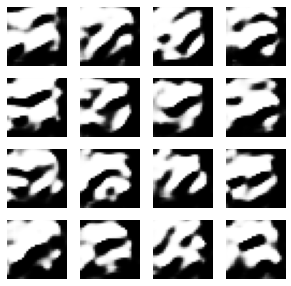

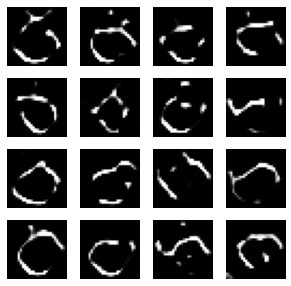

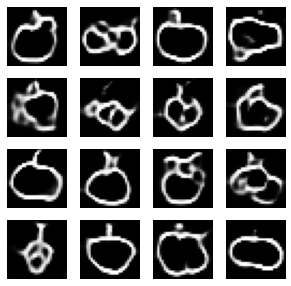

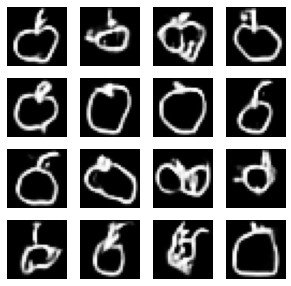

In [14]:
d_metrics_complete, a_metrics_complete = train()

<AxesSubplot:>

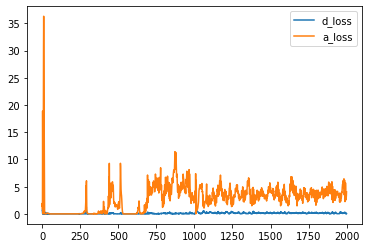

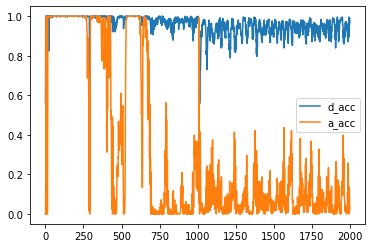

In [15]:
Loss = pd.DataFrame(
    {
        "d_loss": [i[0] for i in d_metrics_complete],
        "a_loss": [i[0] for i in a_metrics_complete]
    }
)

Loss.plot()
#---------------------------------------------------
Acc = pd.DataFrame(
    {
        "d_acc": [i[1] for i in d_metrics_complete],
        "a_acc": [i[1] for i in a_metrics_complete]
    }
)

Acc.plot()

In [16]:
max([i[0] for i in a_metrics_complete])

36.321746826171875